In [113]:
%matplotlib inline
import gym
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from collections import deque
from IPython import display
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from scipy import stats
from training_methods import *
%load_ext autoreload
%autoreload

run_name = 0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
env = gym.make('CartPole-v1')
env.my_preprocess_input = lambda x: x

# env = gym.make('MountainCar-v0')
# env.my_preprocess_input = lambda x: x

# env = gym.make('Breakout-v0')
# env.my_preprocess_input = preprocess_input_breakout_v0

# env = gym.make('Pong-v0')  # Reset TD reward by non-null values
# env.my_preprocess_input = preprocess_input_pong_v0

# env.render(close=True)
# plt.imshow(env.render('rgb_array'))
print('Actions: {}, Observation space {}, parameters {}, max episode steps {}'.format(
    env.action_space.n, env.observation_space.shape, np.prod(env.observation_space.shape), env.spec.max_episode_steps))

[2017-08-27 09:45:26,841] Making new env: CartPole-v1


Actions: 2, Observation space (4,), parameters 4, max episode steps 500


## Basic Actor-Critic

In [115]:
class ActorCriticAgent:
    def __init__(self, params):
        self.params = params
        self.memory_states = []
        self.memory_next_states = []
        self.memory_actions = []
        self.memory_rewards = []
        self._build_actor_model()
        self._build_critic_model()

    def _build_actor_model(self):
        with tf.variable_scope('actor'):
            self.actor_x = tf.placeholder("float", [None, self.params.state_size], name="State")
            self.actor_y = tf.placeholder("float", [None], name="Target")
            self.actor_action = tf.placeholder(tf.int32, [None], name="Action")

            h0 = tf.contrib.layers.fully_connected(
                inputs=self.actor_x,
                num_outputs=20,
                activation_fn=tf.nn.relu,
                weights_initializer=tf.contrib.layers.xavier_initializer())

            h1 = tf.contrib.layers.fully_connected(
                inputs=h0,
                num_outputs=self.params.action_size,
                activation_fn=None,
                weights_initializer=tf.contrib.layers.xavier_initializer())
            
            self.actor_action_probs = tf.nn.softmax(h1)

            actions_ohe = tf.one_hot(self.actor_action, self.params.action_size)
            self.picked_action_probs = tf.reduce_sum(self.actor_action_probs * actions_ohe, axis=1)

            self.actor_cost = tf.reduce_mean(-tf.log(1e-6 + self.picked_action_probs) * self.actor_y)
            self.actor_train_op = tf.train.RMSPropOptimizer(learning_rate=self.params.learning_rate, decay=0.99) \
                .minimize(self.actor_cost)

    def _build_critic_model(self):
        with tf.variable_scope('critic'):
            self.critic_x = tf.placeholder("float", [None, self.params.state_size], name="State")
            self.critic_y = tf.placeholder("float", [None], name="Target")

            h0 = tf.contrib.layers.fully_connected(
                inputs=self.critic_x,
                num_outputs=20,
                activation_fn=tf.nn.relu,
                weights_initializer=tf.contrib.layers.xavier_initializer())

            self.critic_value = tf.contrib.layers.fully_connected(
                inputs=h0,
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.contrib.layers.xavier_initializer())
            
            self.critic_cost = tf.reduce_mean(tf.squared_difference(self.critic_value, self.critic_y))
            self.critic_train_op = tf.train.RMSPropOptimizer(learning_rate=self.params.learning_rate, decay=0.99) \
                .minimize(self.critic_cost)
            
    def remember(self, state, action, reward, next_state, frame):
        self.memory_states.append(state)
        self.memory_next_states.append(next_state)
        self.memory_actions.append(action)
        self.memory_rewards.append(reward)
        
        if len(self.memory_states) > 2 * self.params.max_memory_size:
            self.memory_states = self.memory_states[-self.params.max_memory_size:]
            self.memory_next_states = self.memory_next_states[-self.params.max_memory_size:]
            self.memory_actions = self.memory_actions[-self.params.max_memory_size:]
            self.memory_rewards = self.memory_rewards[-self.params.max_memory_size:]

    def act(self, state, frame):
        if np.random.rand() <= self.params.epsilon:
            return np.random.randint(0, self.params.action_size)
        return self.act_greedy(state, frame)
    
    def act_greedy(self, state, frame):
        act_probs = session.run(self.actor_action_probs, {self.actor_x: [state]})[0]
        return np.random.choice(np.arange(len(act_probs)), p=act_probs)

    def think(self, batch_size, episode):
        cnt = len(self.memory_states)
        States = np.array(self.memory_states)
        Actions = np.array(self.memory_actions)
        Rewards = np.array(self.memory_rewards)
        
        Values = session.run(self.critic_value, {self.critic_x: self.memory_states})
        NextValues = session.run(self.critic_value, {self.critic_x: self.memory_next_states})
        
        CriticY = Rewards.reshape((cnt,1)) + self.params.gamma * NextValues
        ActorY = CriticY - Values
        
        ActorY = ActorY.reshape((cnt,))
        CriticY = CriticY.reshape((cnt,))

        P = np.random.permutation(cnt)
        for i in range(0, cnt, batch_size):
            batch_indexes = P[i: i + batch_size]
            states = States[batch_indexes]
            actorys = ActorY[batch_indexes]
            criticys = CriticY[batch_indexes]
            actions = Actions[batch_indexes]
            
            _ = session.run(self.actor_train_op,
                            {self.actor_x: states, self.actor_y: actorys, self.actor_action: actions})
            _ = session.run(self.critic_train_op,
                            {self.critic_x: states, self.critic_y: criticys})

State shape (4,), actions 2
Run: 4
episode: 3/70, reward 18.0, frames 11, exploration rate: 0.96
episode: 6/70, reward 20.3333333333, frames 21, exploration rate: 0.84
episode: 9/70, reward 17.4444444444, frames 7, exploration rate: 0.74
episode: 12/70, reward 17.2, frames 22, exploration rate: 0.65
episode: 15/70, reward 15.1, frames 10, exploration rate: 0.57
episode: 18/70, reward 15.0, frames 16, exploration rate: 0.5
episode: 21/70, reward 15.7, frames 18, exploration rate: 0.44
episode: 24/70, reward 14.9, frames 11, exploration rate: 0.39
episode: 27/70, reward 20.2, frames 25, exploration rate: 0.34
episode: 30/70, reward 20.7, frames 17, exploration rate: 0.3
episode: 33/70, reward 20.0, frames 13, exploration rate: 0.27
episode: 36/70, reward 22.9, frames 54, exploration rate: 0.23
episode: 39/70, reward 24.5, frames 10, exploration rate: 0.21
episode: 42/70, reward 25.6, frames 12, exploration rate: 0.18
episode: 45/70, reward 24.9, frames 39, exploration rate: 0.16
episode:

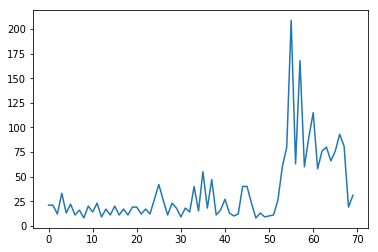

In [119]:
import time
start_time = time.time()

params = LearningParameters(env, episodes_count=70)
params.max_frame_in_episode = min(params.max_frame_in_episode, 1000)
params.epsilon_min = 0.05

if 'session' in locals():
    session.close()
    tf.reset_default_graph()
    if 'tf_writer' in locals():
        tf_writer.close()
config = tf.ConfigProto(device_count = {'GPU': 0})
session = tf.Session(config=config)
# session = tf.Session()
run_name += 1
print('Run: ' + str(run_name))

agent = ActorCriticAgent(params)

tf_writer = tf.summary.FileWriter('logs/run' + str(run_name), session.graph)

session.run(tf.global_variables_initializer())

agent, rewards = train_discounted_rewards(env, agent, params, normalize_rewards=True)
# agent, rewards = train_reward_is_time(env, agent, params)
# agent, rewards = train(env, agent, params)
plt.plot(rewards)

end_time = time.time()
print('Elapsed: {}, frames per second {}'.format(end_time - start_time, np.sum(rewards) / (end_time - start_time)))

In [22]:
# Continue learning
params.episodes_count = 500
agent, rewards = train_discounted_rewards(env, agent, params, normalize_rewards=True)
plt.plot(rewards)

KeyboardInterrupt: 

In [21]:
evaluate(env, agent, params, 500)

Total reward: -500.0


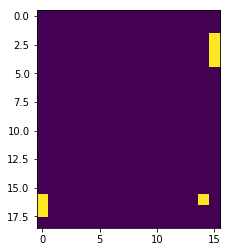

In [17]:
show(env, agent, params, 500, width=19, height=16, greedy=True)

In [18]:
# Save rewards/model
# pd.DataFrame(rewards).to_csv('models/rewards_40K_50K.csv', header=None)
saver = tf.train.Saver()
saver.save(session, 'models/Pong ActorCriticAgent', global_step=9000)

'models/Pong ActorCriticAgent-9000'